In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from scipy.integrate import odeint
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
def lorenz_deriv(state, t, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x*(rho - z) - y
    dzdt = x*y - beta*z
    return [dxdt, dydt, dzdt]

def generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=25.0,
    dt=0.01,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
):
    num_steps = int(tmax / dt)
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(lorenz_deriv, initial_state, t_vals, args=(sigma, rho, beta))
    return t_vals, sol

In [3]:
def scale_spectral_radius(W, target_radius=0.95):
    """
    Scales a matrix W so that its largest eigenvalue magnitude = target_radius.
    """
    eigvals = np.linalg.eigvals(W)
    radius = np.max(np.abs(eigvals))
    if radius == 0:
        return W
    return (W / radius) * target_radius

In [4]:
class ESN3D:
    """
    Dense random ESN for 3D->3D single-step.
    Teacher forcing for training, autoregressive for testing.
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        W = np.random.randn(reservoir_size, reservoir_size)*0.1
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed+1)
        self.W_in = (np.random.rand(reservoir_size,3) - 0.5)*2.0*self.input_scale
        # self.W_in = np.random.uniform(-self.input_scale, self.input_scale, (reservoir_size, 3))

        self.W_out = None
        self.x = np.zeros(reservoir_size)

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]
        X_aug = np.hstack([states_use, np.ones((states_use.shape[0],1))])
        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            x_aug = np.concatenate([self.x, [1.0]])
            out = self.W_out @ x_aug
            preds.append(out)
            current_in = out
        return np.array(preds)

In [5]:
class CR3D:
    """
    Cycle (ring) reservoir for 3D->3D single-step,
    teacher forcing for training, autoregressive for testing.
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            j = (i+1) % reservoir_size
            W[i, j] = 1.0
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W
        
        np.random.seed(self.seed+1)
        self.W_in = (np.random.rand(reservoir_size,3) - 0.5)*2.0*self.input_scale

        self.W_out = None
        self.x = np.zeros(reservoir_size)

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]
        X_aug = np.hstack([states_use, np.ones((states_use.shape[0],1))])
        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            x_aug = np.concatenate([self.x, [1.0]])
            out = self.W_out @ x_aug
            preds.append(out)
            current_in = out
        return np.array(preds)

In [6]:
class SparseESN3D:
    """
    Sparse random ESN for 3D->3D single-step,
    teacher forcing for training, autoregressive for testing.
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 connectivity=0.05,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        W_full = np.random.randn(reservoir_size, reservoir_size)*0.1
        mask = (np.random.rand(reservoir_size, reservoir_size) < self.connectivity)
        W = W_full * mask
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed+1)
        self.W_in = (np.random.rand(reservoir_size,3) - 0.5)*2.0*self.input_scale

        self.W_out = None
        self.x = np.zeros(reservoir_size)

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]
        X_aug = np.hstack([states_use, np.ones((states_use.shape[0],1))])
        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            x_aug = np.concatenate([self.x, [1.0]])
            out = self.W_out @ x_aug
            preds.append(out)
            current_in = out
        return np.array(preds)

In [7]:
class SAR3D:
    """
    Self-Attention Reservoir (SAR) for 3D->3D single-step tasks.
    We maintain:
      - A base reservoir_size dimension
      - random queries Qi and keys Kj for each node i,j (embedding_dim)
      - data-driven adjacency a_ij(t) = softmax_j( Q_i^T * K_j * x_j(t)? ).

    We'll do:
      s_{ij} = Q_i^T K_j * x_j(t)
      a_{ij}(t) = softmax over j of s_{ij}
      Then x_i(t+1) = (1-alpha)*x_i(t) + alpha*tanh( sum_j a_{ij}(t)*x_j(t) + W_in_i * u(t) ).

    We keep Q,K random so we only train readout in ESN style.
    """
    def __init__(self,
                 reservoir_size=300,
                 embedding_dim=16,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.embedding_dim = embedding_dim
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        # We'll keep a base adjacency for fallback or partial usage
        # (But we can set it to small scale or keep it for optional usage. We'll decide later.)
        np.random.seed(self.seed)
        W_base = np.random.randn(reservoir_size, reservoir_size)*0.1
        W_base = scale_spectral_radius(W_base, self.spectral_radius*0.4)  # 0.0 => no static adjacency for now
        self.W_base = W_base  # possibly we won't use it 

        # Input weights
        np.random.seed(self.seed+1)
        self.W_in = (np.random.rand(reservoir_size,3) - 0.5)*2.0*self.input_scale

        # Query/Key embeddings for each node i
        np.random.seed(self.seed+2)
        self.Q = np.random.randn(reservoir_size, embedding_dim)*0.1  # Qi in R^embedding_dim
        np.random.seed(self.seed+3)
        self.K = np.random.randn(reservoir_size, embedding_dim)*0.1  # Kj in R^embedding_dim

        self.x = np.zeros(reservoir_size)
        self.W_out = None

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _compute_attention(self, x_vec):
        """
        x_vec shape => (reservoir_size,)
        We'll produce a dynamic adjacency a_{ij} using:
          s_{ij} = (Q_i dot K_j) * x_j
        Then row-wise softmax over j for each i.
        We'll get a matrix a(t) shape => (N, N).
        """
        N = self.reservoir_size
        # compute s_{ij}
        # Q_i dot K_j => shape => (N, N)
        # then multiply by x_j(t)
        # We'll do outer product Q*K => shape (N,N), then multiply columns by x_j
        # we can do it in vectorized form:
        # Q => shape (N, embedding_dim), K => shape (N, embedding_dim)
        # Q*K^T => shape (N,N) => s_base
        s_base = self.Q @ self.K.T   # shape (N, N)
        # then s_{ij} = s_base_{ij} * x_j
        # We'll broadcast x_j across columns. s_ij = s_base_{ij} * x_j(t)
        # So for row i, we multiply each column j by x_j.
        # s(t) => shape (N, N)
        s_mat = s_base * x_vec[None,:]

        # Now row-wise softmax
        # for each i, a_i(t) = softmax( s_mat[i,:] ), shape => (N,)
        a = np.zeros((N,N))
        for i in range(N):
            row = s_mat[i,:]
            row_max = np.max(row)
            exp_row = np.exp(row - row_max)
            sum_exp = np.sum(exp_row)
            if sum_exp < 1e-12:
                a[i,:] = 0.0
            else:
                a[i,:] = exp_row / sum_exp

        return a  # shape => (N,N)

    def _update(self, u):
        """
        x(t+1) = (1-alpha)*x(t) + alpha*tanh( sum_j a_{ij}(t)* x_j(t) + W_in_i * u(t) ).
        We'll ignore W_base or set it to zero if we want purely attention-based adjacency.
        """
        a_mat = self._compute_attention(self.x)  # shape => (N,N)

        # sum_j a_ij(t)* x_j(t)
        attn_input = a_mat @ self.x  # shape => (N,)

        # plus input from W_in * u(t)
        input_term = self.W_in @ u   # shape => (N,)

        pre_activation = attn_input + input_term
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        """
        Teacher forcing => real input each step => dynamic adjacency => reservoir states
        """
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        # shape => [T, reservoir_size]
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard=discard)
        target_use = train_target[discard:]
        # augment with bias
        X_aug = np.hstack([states_use, np.ones((states_use.shape[0],1))])
        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, target_use)
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        preds = []
        #self.reset_state()
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            x_aug = np.concatenate([self.x, [1.0]])
            out = self.W_out @ x_aug
            preds.append(out)
            current_in = out
        return np.array(preds)


In [8]:
def augment_state_with_squares(x):
    """
    Given state vector x in R^N, return [ x, x^2, 1 ] in R^(2N+1).
    We'll use this for both training and prediction.
    """
    x_sq = x**2
    return np.concatenate([x, x_sq, [1.0]])  # shape: 2N+1

In [9]:
class CRJ3D:
    """
    Cycle Reservoir with Jumps (CRJ) for 3D->3D single-step tasks.
    We form a ring adjacency with an extra 'jump' edge in each row.
    This can help capture multiple timescales or delayed memory
    while retaining the easy ring structure.

    The adjacency is built as follows (mod reservoir_size = N):
      For each i in [0..N-1]:
        W[i, (i+1) mod N] = 1.0
        W[i, (i+jump) mod N] = 1.0
    Then we scale by 'spectral_radius.' We do an ESN update
    with readout [ x, x^2, 1 ] -> next step in R^3.
    """

    def __init__(self,
                 reservoir_size=300,
                 jump=10,                # offset for the jump
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        """
        reservoir_size: how many nodes in the ring
        jump         : the offset for the 2nd connection from node i
        spectral_radius : scale adjacency
        input_scale  : scale factor for W_in
        leaking_rate : ESN 'alpha'
        ridge_alpha  : ridge penalty for readout
        seed         : random seed
        """
        self.reservoir_size = reservoir_size
        self.jump = jump
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        # build adjacency
        np.random.seed(self.seed)
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            # cycle edge: i -> (i+1)%N
            W[i, (i+1) % reservoir_size] = 1.0
            # jump edge: i -> (i+jump)%N
            W[i, (i + self.jump) % reservoir_size] = 1.0

        # scale spectral radius
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        # input weights => shape [N,3]
        np.random.seed(self.seed+100)
        W_in = (np.random.rand(reservoir_size, 3) - 0.5)*2.0*self.input_scale
        self.W_in = W_in

        # readout
        self.W_out = None
        self.x = np.zeros(self.reservoir_size)

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        """
        Single-step ESN update:
          x(t+1) = (1-alpha)*x(t) + alpha*tanh( W x(t) + W_in u(t) )
        """
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        """
        Teacher forcing => feed the real 3D inputs => gather states.
        Return (states_after_discard, states_discarded).
        """
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        """
        gather states => polynomial readout => solve ridge
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        target_use = train_target[discard:]
        X_list = []
        for s in states_use:
            # polynomial expansion => [ x, x^2, 1 ]
            X_list.append( augment_state_with_squares(s) )
        X_aug = np.array(X_list)

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, target_use)
        self.W_out = reg.coef_  # shape => (3, 2N+1)

    def predict_autoregressive(self, initial_input, n_steps):
        """
        fully autoregressive => feed last output => next input
        """
        preds = []
        #self.reset_state()
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            big_x = augment_state_with_squares(self.x)
            out = self.W_out @ big_x  # shape => (3,)
            preds.append(out)
            current_in = out
        return np.array(preds)

In [10]:
class MCI3D:
    """
    Minimum Complexity Interaction ESN (MCI-ESN).

    This class implements the approach described in:
      "A Minimum Complexity Interaction Echo State Network"
        by Jianming Liu, Xu Xu, Eric Li (2024).
    
    The model structure:
      - We maintain two 'simple cycle' reservoirs (each of size N).
      - Each reservoir is a ring with weight = l, i.e. 
            W_res[i, (i+1)%N] = l
        plus the corner wrap from (N-1)->0, also = l.
      - The two reservoirs interact via a minimal connection matrix: 
         exactly 2 cross-connections with weight = g. 
         (One might connect x2[-1], x2[-2], ... 
          But we do wehre reservoir1 sees x2[-1] 
          in one location, and reservoir2 sees x1[-1] likewise.)
      - Activation function in reservoir1 is cos(·), and in reservoir2 is sin(·).
      - They each have a separate input weight matrix: Win1 and Win2. 
        The final state is a linear combination 
           x(t) = h*x1(t) + (1-h)*x2(t).
      - Then we do a polynomial readout [x, x^2, 1] -> output.
      - We feed teacher forcing in collect_states, 
        then solve readout with Ridge regression.

    References:
      - Liu, J., Xu, X., & Li, E. (2024). 
        "A minimum complexity interaction echo state network," 
         Neural Computing and Applications.
    
    notes:
      - The reservoir_size is N for each reservoir, 
        so total param dimension is 2*N for states, 
        but we produce a single final "combined" state x(t) in R^N for readout.
      - The activation f1=cos(...) for reservoir1, f2=sin(...) for reservoir2, 
        as recommended by the paper for MCI-ESN.

    """

    def __init__(
        self,
        reservoir_size=500,
        cycle_weight=0.9,      # 'l' in the paper
        connect_weight=0.9,    # 'g' in the paper
        input_scale=0.2,
        leaking_rate=1.0,
        ridge_alpha=1e-6,
        combine_factor=0.5,    # 'h' in the paper
        seed=42
    ):
        """
        reservoir_size: N, size of each cycle reservoir 
        cycle_weight : l, ring adjacency weight in [0,1), ensures cycle synergy
        connect_weight: g, cross-connection weight between the two cycle reservoirs
        input_scale   : scale factor for input->reservoir weights
        leaking_rate  : ESN update alpha 
        ridge_alpha   : readout ridge penalty
        combine_factor: h in [0,1], to form x(t)= h*x1(t)+(1-h)*x2(t) as final combined state
        seed          : random seed
        """
        self.reservoir_size = reservoir_size
        self.cycle_weight   = cycle_weight
        self.connect_weight = connect_weight
        self.input_scale    = input_scale
        self.leaking_rate   = leaking_rate
        self.ridge_alpha    = ridge_alpha
        self.combine_factor = combine_factor
        self.seed           = seed

        # We'll define (and build) adjacency for each cycle, 
        # plus cross-connection for two sub-reservoirs.
        # We'll define 2 input weight mats: Win1, Win2.
        # We'll define states x1(t), x2(t).
        # We'll define readout W_out after training.

        self._build_mci_esn()

    def _build_mci_esn(self):
        """
        Build all the internal parameters: 
         - ring adjacency for each reservoir
         - cross-reservoir connection
         - input weights for each reservoir
         - initial states
        """
        np.random.seed(self.seed)

        N = self.reservoir_size

        # Build ring adjacency W_res in shape [N, N], with cycle_weight on ring
        W_res = np.zeros((N, N))
        for i in range(N):
            j = (i+1) % N
            W_res[j, i] = self.cycle_weight
        self.W_res = W_res  # shared by both sub-reservoirs

        # Build cross-connection W_cn for shape [N,N], 
        # minimal 2 nonzero elements. 
        # For the simplest approach from the paper:
        #   W_cn[0, N-1] = g, W_cn[1, N-2] = g or similar.
        # The paper's eq(7) suggests the last 2 elements in x(t) cross to first 2 in the other reservoir:
        # We'll do the simplest reference: if i=0 or i=1, we connect from the other reservoir's last or second-last. 
        # We'll define a function for each sub-res to pick up from the other sub-res. 
        # We can store them in separate arrays, or define them in code. 
        # We'll just store "We want index 0 to see x2[-1], index 1 to see x2[-2]."

        # But as done in the original code snippet from the paper:
        #   Wcn has
        # effectively 2 nonzero positions. We'll define that pattern:
        W_cn = np.zeros((N, N))
        # e.g. W_cn[0, N-1] = g, W_cn[N-1, N-2] = g or something. 
        # The paper example used W_cn = diag(0,g,...) plus the corner. We'll do the simplest:
        # let W_cn[0, N-1]=g, W_cn[1, N-2]=g.
        # This matches the minimal cross. 
        # For clarity we do:
        W_cn[0, N-1] = self.connect_weight
        if N>1:
            W_cn[1, N-2] = self.connect_weight
        self.W_cn = W_cn

        # We'll define input weights for each sub-reservoir, shape [N, dim_input].
        # The paper sets them as eq(10) in the snippet, with different signs. 
        # We'll define them as parted. 
        # We define V1, V2 => shape [N, dim_input], with constant magnitude t1, t2, random sign. 
        # We'll do random. Need to check this in the paper again
        # We'll keep "two" separate. user can define input_scale but not two separate. 
        # We'll do the simplest approach: the absolute value is the same => input_scale, 
        # sign is random. Then we define Win1 = V1 - V2, Win2 = V1 + V2.
        # This is consistent with eq(10) from the paper.

        self.Win1 = None
        self.Win2 = None

        # We'll define states x1(t), x2(t). We'll do them after dimension known. 
        self.x1 = None
        self.x2 = None

        self.W_out = None

    def _init_substates(self):
        """
        Once we know reservoir_size, we define x1, x2 as zeros. 
        We'll call this in reset_state or at fit time.
        """
        N = self.reservoir_size
        self.x1 = np.zeros(N)
        self.x2 = np.zeros(N)

    def reset_state(self):
        if self.x1 is not None:
            self.x1[:] = 0.0
        if self.x2 is not None:
            self.x2[:] = 0.0

    def _update(self, u):
        """
        Single-step reservoir update.
        x1(t+1) = cos( Win1*u(t+1) + W_res*x1(t) + W_cn*x2(t) )
        x2(t+1) = sin( Win2*u(t+1) + W_res*x2(t) + W_cn*x1(t) )
        Then x(t)= h*x1(t+1) + (1-h)* x2(t+1).
        We'll define the leaky integration. 
        But the paper uses an approach with no leak? Be careful.
        We'll do the approach: x1(t+1)= (1-alpha)* x1(t) + alpha*cos(...).
        """
        alpha = self.leaking_rate

        # pre activation for reservoir1
        pre1 = self.Win1 @ u + self.W_res @ self.x1 + self.W_cn @ self.x2
        # reservoir1 uses cos
        new_x1 = np.cos(pre1)

        # reservoir2 uses sin
        pre2 = self.Win2 @ u + self.W_res @ self.x2 + self.W_cn @ self.x1
        new_x2 = np.sin(pre2)

        self.x1 = (1.0 - alpha)*self.x1 + alpha*new_x1
        self.x2 = (1.0 - alpha)*self.x2 + alpha*new_x2

    def _combine_state(self):
        """
        Combine x1(t), x2(t) => x(t) = h*x1 + (1-h)*x2
        """
        h = self.combine_factor
        return h*self.x1 + (1.0 - h)*self.x2



    def collect_states(self, inputs, discard=100):
        # We reset the reservoir to zero
        self.reset_state()
        states = []
        for t in range(len(inputs)):
            self._update(inputs[t])   # feed the REAL input from the dataset
            combined = self._combine_state()
            states.append(combined.copy())
        states = np.array(states)  # shape => [T, N]
        return states[discard:], states[:discard]


    def fit_readout(self, train_input, train_target, discard=100):
        """
        Build input weights if needed, gather states on the training data (teacher forcing),
        then solve a polynomial readout [x, x^2, 1]->train_target(t).

        train_input : shape [T, d_in]
        train_target: shape [T, d_out]
        discard     : # of states to discard for warmup
        """
        T = len(train_input)
        if T<2:
            raise ValueError("Not enough training data")

        d_in = train_input.shape[1]
        d_out = train_target.shape[1]

        # built Win1, Win2
        if self.Win1 is None or self.Win2 is None:
            np.random.seed(self.seed+100)
            # build V1, V2 in shape [N, d_in]
            N = self.reservoir_size
            V1 = (np.random.rand(N, d_in)-0.5)*2.0*self.input_scale
            V2 = (np.random.rand(N, d_in)-0.5)*2.0*self.input_scale
            # eq(10): Win1= V1 - V2, Win2= V1 + V2
            self.Win1 = V1 - V2
            self.Win2 = V1 + V2

        # define x1, x2
        self._init_substates()

        # gather states
        states_use, _ = self.collect_states(train_input, discard=discard)
        target_use = train_target[discard:]  # shape => [T-discard, d_out]

        # polynomial readout
        X_list = []
        for s in states_use:
            X_list.append( augment_state_with_squares(s) )
        X_aug = np.array(X_list)  # shape => [T-discard, 2N+1]

        # Solve ridge
        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, target_use)
        # W_out => shape [d_out, 2N+1]
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        """
        Fully autoregressive: 
          We do not use teacher forcing, 
          we feed the model's last output as the next input 
        Typically, for MCI-ESN the paper does input(t+1) in R^d. 
        We do the test_input
        For multi-step chaotic forecast, we feed the model's output as input? 
        That means the system dimension d_in must match d_out. 
        """
        preds = []
        # re-init states
        #self._init_substates()

        # we assume initial_input => shape (d_in,)
        current_in = np.array(initial_input)

        for _ in range(n_steps):
            self._update(current_in)
            # read out
            combined = self._combine_state()
            big_x = augment_state_with_squares(combined)
            out = self.W_out @ big_x  # shape => (d_out,)

            preds.append(out)
            current_in = out  # feed output back as next input

        return np.array(preds)

In [11]:
def mse_dimwise(pred, truth):
    length = min(len(pred), len(truth))
    return np.mean((pred[:length] - truth[:length])**2, axis=0)

In [12]:
def compute_valid_prediction_time(y_true, y_pred, t_vals, threshold=0.4, lambda_max=0.9):
    """
    Compute the Valid Prediction Time (VPT) and compare it to Lyapunov time T_lambda = 1 / lambda_max.
    
    Parameters
    ----------
    y_true : ndarray of shape (N, dim)
        True trajectory over time.
    y_pred : ndarray of shape (N, dim)
        Model's predicted trajectory over time (closed-loop).
    t_vals : ndarray of shape (N,)
        Time values corresponding to the trajectory steps.
    threshold : float, optional
        The error threshold, default is 0.4 as in your snippet.
    lambda_max : float, optional
        Largest Lyapunov exponent. Default=0.9 for Lorenz.
        
    Returns
    -------
    T_VPT : float
        Valid prediction time. The earliest time at which normalized error surpasses threshold
        (or the last time if never surpassed).
    T_lambda : float
        Lyapunov time = 1 / lambda_max
    ratio : float
        How many Lyapunov times the model prediction remains valid, i.e. T_VPT / T_lambda.
    """
    # 1) Average of y_true
    y_mean = np.mean(y_true, axis=0)  # shape (dim,)
    
    # 2) Time-averaged norm^2 of (y_true - y_mean)
    y_centered = y_true - y_mean
    denom = np.mean(np.sum(y_centered**2, axis=1))  # scalar
    
    # 3) Compute the normalized error delta_gamma(t) = ||y_true - y_pred||^2 / denom
    diff = y_true - y_pred
    err_sq = np.sum(diff**2, axis=1)  # shape (N,)
    delta_gamma = err_sq / denom      # shape (N,)
    
    # 4) Find the first time index where delta_gamma(t) exceeds threshold
    idx_exceed = np.where(delta_gamma > threshold)[0]
    if len(idx_exceed) == 0:
        # never exceeds threshold => set T_VPT to the final time
        T_VPT = t_vals[-1]
    else:
        T_VPT = t_vals[idx_exceed[0]]
    
    # 5) Compute T_lambda and ratio
    T_lambda = 1.0 / lambda_max
    ratio = T_VPT / T_lambda

    # 6) Valid Prediction Time (VPT)
    lambda_max_lorenz = 0.9
    threshold = 0.4
    print(f"\n--- Valid Prediction Time (VPT) with threshold={threshold}, lambda_max={lambda_max_lorenz} ---")
    
    return T_VPT, T_lambda, ratio

In [13]:
def report_vpt(name, preds, test_target, time_test, threshold=0.4, lambda_max_lorenz=0.9):
    T_VPT, T_lambda, ratio = compute_valid_prediction_time(
        test_target, preds, time_test, threshold=threshold, lambda_max=lambda_max_lorenz
    )
    print(f"{name:20s} => T_VPT={T_VPT:.3f},  T_lambda={T_lambda:.3f}, ratio={ratio:.3f}")

In [14]:
def nrmse_dimwise(pred, truth):
    length = min(len(pred), len(truth))
    pred = pred[:length]
    truth = truth[:length]
    mse = np.mean((pred - truth) ** 2, axis=0)
    std = np.std(truth, axis=0)
    # Avoid division by zero
    std[std == 0] = 1e-8
    return np.sqrt(mse) / std

Data length: 5000, from t=0..50.0 with dt=0.01.
Train size: 3999  Test size: 1000

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
Dense ESN            => T_VPT=40.378,  T_lambda=1.111, ratio=36.340

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
Cycle Res            => T_VPT=40.248,  T_lambda=1.111, ratio=36.223

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
Sparse ESN           => T_VPT=40.418,  T_lambda=1.111, ratio=36.376

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
SelfAttention        => T_VPT=45.269,  T_lambda=1.111, ratio=40.742

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
CRJ                  => T_VPT=40.538,  T_lambda=1.111, ratio=36.484

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
MCI                  => T_VPT=47.670,  T_lambda=1.111, ratio=42.903

--- Multi-step Autoregressive MSE (x, y, z) ---
Dense ESN    : [ 1.88152974  

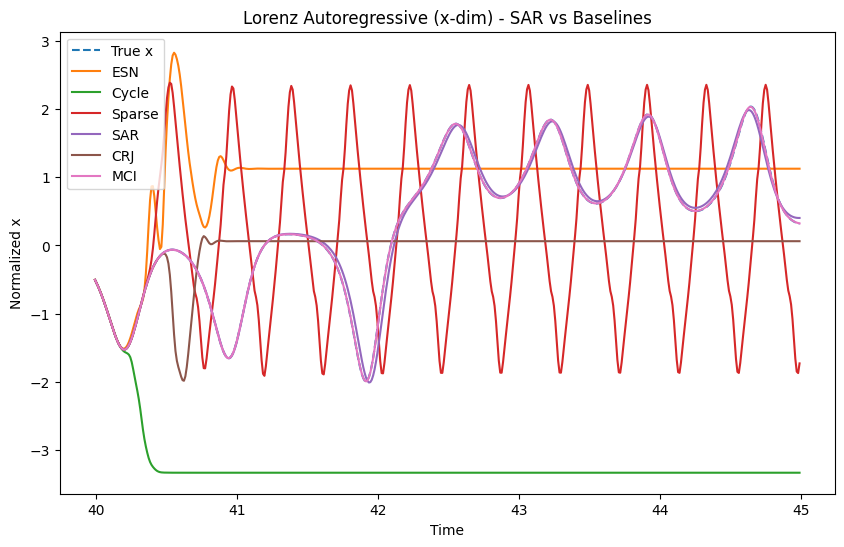

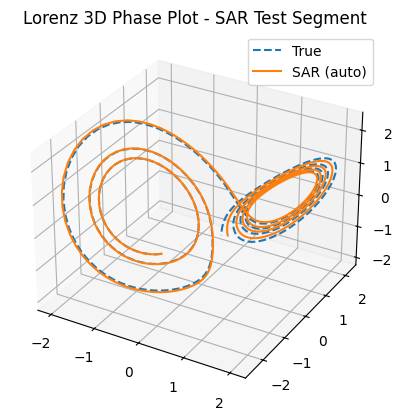

In [16]:
def main():
    # 1) Generate Lorenz data
    tmax = 50.0
    dt   = 0.01
    t_vals, lorenz_traj = generate_lorenz_data(
        initial_state=[1.0,1.0,1.0],
        tmax=tmax,
        dt=dt
    )

    # normalize
    scaler = StandardScaler()
    scaler.fit(lorenz_traj)
    lorenz_traj = scaler.transform(lorenz_traj)

    T_data = len(lorenz_traj)
    print(f"Data length: {T_data}, from t=0..{tmax} with dt={dt}.")

    # train/test split
    train_frac = 0.8
    train_end = int(train_frac*(T_data-1))
    train_input  = lorenz_traj[:train_end]
    train_target = lorenz_traj[1:train_end+1]
    test_input   = lorenz_traj[train_end:-1]
    test_target  = lorenz_traj[train_end+1:]
    print(f"Train size: {len(train_input)}  Test size: {len(test_input)}")

    # (a) Baseline ESN
    esn = ESN3D(
        reservoir_size=300,
        spectral_radius=0.95,
        input_scale=1.0,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=42
    )
    esn.fit_readout(train_input, train_target, discard=100)

    # (b) Cycle Reservoir
    cycle_res = CR3D(
        reservoir_size=300,
        spectral_radius=0.95,
        input_scale=1.0,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=43
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)

    # (c) Sparse ESN
    sparse_res = SparseESN3D(
        reservoir_size=300,
        spectral_radius=0.95,
        connectivity=0.04,
        input_scale=1.0,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=44
    )
    sparse_res.fit_readout(train_input, train_target, discard=100)

    # (d) Self-Attention Reservoir (SAR)
    sar = SAR3D(
        reservoir_size=300,
        embedding_dim=32, # increasing dim would perhaps lead to better performance though at the cost of compute (32 seems to be optimal)
        #spectral_radius=0.99,   # set base adjacency effectively 0
        input_scale=1.0,
        leaking_rate=0.9,
        ridge_alpha=1e-6,
        seed=45
    )
    sar.fit_readout(train_input, train_target, discard=100)

    # (e) Cycle Reservoir with Jumps (CRJ)
    crj = CRJ3D(
        reservoir_size=300,
        jump=10,                # offset for the jump
        spectral_radius=0.95,
        input_scale=1.0,
        leaking_rate=1.0,
        ridge_alpha=1e-6,
        seed=42
    )
    crj.fit_readout(train_input, train_target, discard=100)

    mci = MCI3D(
        reservoir_size=500,
        cycle_weight=0.9,      # 'l' in the paper
        connect_weight=0.9,    # 'g' in the paper
        input_scale=0.2,
        leaking_rate=1.0,
        ridge_alpha=1e-6,
        combine_factor=0.5,    # 'h' in the paper
        seed=47
    )
    mci.fit_readout(train_input, train_target, discard=100)

    # 3) Autoregressive testing
    n_test_steps = len(test_input)
    initial_in = test_input[0]

    esn_preds    = esn.predict_autoregressive(initial_in, n_test_steps)
    cycle_preds  = cycle_res.predict_autoregressive(initial_in, n_test_steps)
    sparse_preds = sparse_res.predict_autoregressive(initial_in, n_test_steps)
    sar_preds    = sar.predict_autoregressive(initial_in, n_test_steps)
    crj_preds = crj.predict_autoregressive(initial_in, n_test_steps)
    mci_preds = mci.predict_autoregressive(initial_in, n_test_steps)


    mse_esn    = mse_dimwise(esn_preds,    test_target)
    mse_cycle  = mse_dimwise(cycle_preds,  test_target)
    mse_sparse = mse_dimwise(sparse_preds, test_target)
    mse_sar    = mse_dimwise(sar_preds,    test_target)
    mse_crj    = mse_dimwise(crj_preds,    test_target)
    mse_mci    = mse_dimwise(mci_preds,    test_target)

    nrmse_esn    = nrmse_dimwise(esn_preds,    test_target)
    nrmse_cycle  = nrmse_dimwise(cycle_preds,  test_target)
    nrmse_sparse = nrmse_dimwise(sparse_preds, test_target)
    nrmse_sar    = nrmse_dimwise(sar_preds,    test_target)
    nrmse_crj    = nrmse_dimwise(crj_preds,    test_target)
    nrmse_mci    = nrmse_dimwise(mci_preds,    test_target)

    report_vpt("Dense ESN",    esn_preds,    test_target, t_vals[train_end:], threshold=0.4, lambda_max_lorenz=0.9)
    report_vpt("Cycle Res",    cycle_preds,  test_target, t_vals[train_end:], threshold=0.4, lambda_max_lorenz=0.9)
    report_vpt("Sparse ESN",   sparse_preds, test_target, t_vals[train_end:], threshold=0.4, lambda_max_lorenz=0.9)
    report_vpt("SelfAttention", sar_preds,    test_target, t_vals[train_end:], threshold=0.4, lambda_max_lorenz=0.9)
    report_vpt("CRJ",         crj_preds,    test_target, t_vals[train_end:], threshold=0.4, lambda_max_lorenz=0.9)
    report_vpt("MCI",         mci_preds,    test_target, t_vals[train_end:], threshold=0.4, lambda_max_lorenz=0.9)
    
    print("\n--- Multi-step Autoregressive MSE (x, y, z) ---")
    print("Dense ESN    :",  mse_esn)
    print("Cycle Res    :",  mse_cycle)
    print("Sparse ESN   :",  mse_sparse)
    print("SelfAttention:",  mse_sar)
    print("CRJ          :",  mse_crj)
    print("MCI          :",  mse_mci)    
    
    print("\n--- Multi-step Autoregressive NRMSE (x, y, z) ---")
    print("Dense ESN    :",  nrmse_esn)
    print("Cycle Res    :",  nrmse_cycle)
    print("Sparse ESN   :",  nrmse_sparse)
    print("SelfAttention:",  nrmse_sar)
    print("CRJ          :",  nrmse_crj)
    print("MCI          :",  nrmse_mci)

    # 4) partial trajectory
    plot_len = min(500, n_test_steps)
    time_test = np.linspace(train_end*dt, (train_end+plot_len)*dt, plot_len)

    plt.figure(figsize=(10,6))
    plt.plot(time_test, test_target[:plot_len,0], label='True x', linestyle='--')
    plt.plot(time_test, esn_preds[:plot_len,0],    label='ESN')
    plt.plot(time_test, cycle_preds[:plot_len,0],  label='Cycle')
    plt.plot(time_test, sparse_preds[:plot_len,0], label='Sparse')
    plt.plot(time_test, sar_preds[:plot_len,0],    label='SAR')
    plt.plot(time_test, crj_preds[:plot_len,0],    label='CRJ')
    plt.plot(time_test, mci_preds[:plot_len,0],    label='MCI')
    
    plt.title('Lorenz Autoregressive (x-dim) - SAR vs Baselines')
    plt.xlabel('Time')
    plt.ylabel('Normalized x')
    plt.legend()
    plt.show()

    # 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot(test_target[:plot_len,0], test_target[:plot_len,1], test_target[:plot_len,2],
            label='True', linestyle='--')
    ax.plot(sar_preds[:plot_len,0], sar_preds[:plot_len,1], sar_preds[:plot_len,2],
            label='SAR (auto)')
    ax.set_title('Lorenz 3D Phase Plot - SAR Test Segment')
    ax.legend()
    plt.show()

if __name__ == "__main__":
    main()